>### Reference
- https://keras.io/examples/vision/edsr/
- Deep learning with Python 2nd
- 빵형 Youtube

>### imports

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import PIL.Image
import cv2, os, glob
from skimage.transform import pyramid_expand
from skimage.transform import pyramid_reduce 

import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

plt.style.use('dark_background')    

import warnings
warnings.filterwarnings(action='ignore')

def fn_makedirs(path): 
   try: 
        os.makedirs(path) 
   except OSError: 
       if not os.path.isdir(path): 
           raise

>### 데이터 전처리(preprocessing)
- 1) 데이터는 네트워크에 주입되기 전에 부동 소수점 타입의 텐서로 적절하게 전처리
- 2) 사진 피일을 읽는다.
- 3) JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다.
- 4) 그 다음, 부동 소수점 타입의 텐서로 변환
- 5) 동일한 크기의 이미지로 변경
- 6) 배치로 묶는다.

>### Download / load the training dataset

In [24]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)

data_dir = pathlib.Path(data_dir)

In [25]:
print('data_dir:', data_dir, type(data_dir))

data_dir: C:\Users\sel04327\.keras\datasets\flower_photos <class 'pathlib.WindowsPath'>


>### directory 구조
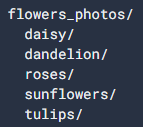

>### data의 갯수 확인

In [26]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_list = list(data_dir.glob('*/*.jpg'))
print(image_count)
print(image_list[:3])

3670
[WindowsPath('C:/Users/sel04327/.keras/datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'), WindowsPath('C:/Users/sel04327/.keras/datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'), WindowsPath('C:/Users/sel04327/.keras/datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg')]


>### 데이터 출력

C:\Users\sel04327\.keras\datasets\flower_photos\roses\10090824183_d02c613f10_m.jpg
roses count: 641


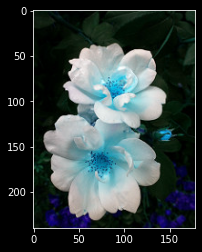

In [27]:
roses = sorted(list(data_dir.glob('roses/*')))
print(roses[0])

roses_cnt = len(roses)
print('roses count:', roses_cnt)

img_sample = cv2.imread(os.path.join(roses[0]))
plt.imshow(img_sample)

In [28]:
print('sample의 형태: ', img_sample.shape)

shape_list = []
for idx, image in enumerate(image_list):
    _ = cv2.imread(os.path.join(image))
    shape_list.append(_.shape)

print('image_list 중, 최소사이즈:', min(shape_list))

cnt = 0
idx_list = []
for idx, item in enumerate(shape_list):
    if item < (200, 200):
        cnt += 1
        idx_list.append(idx)
        
print(cnt)
print(idx_list)

sample의 형태:  (240, 179, 3)
image_list 중, 최소사이즈: (159, 240, 3)
16
[276, 420, 444, 597, 2297, 2498, 2522, 2886, 2959, 3020, 3121, 3193, 3310, 3324, 3332, 3494]


>### Sample 데이터 check
- Crop / DownScale 통해, Low / High resolution(input/target) 만들기

240 179
0 1


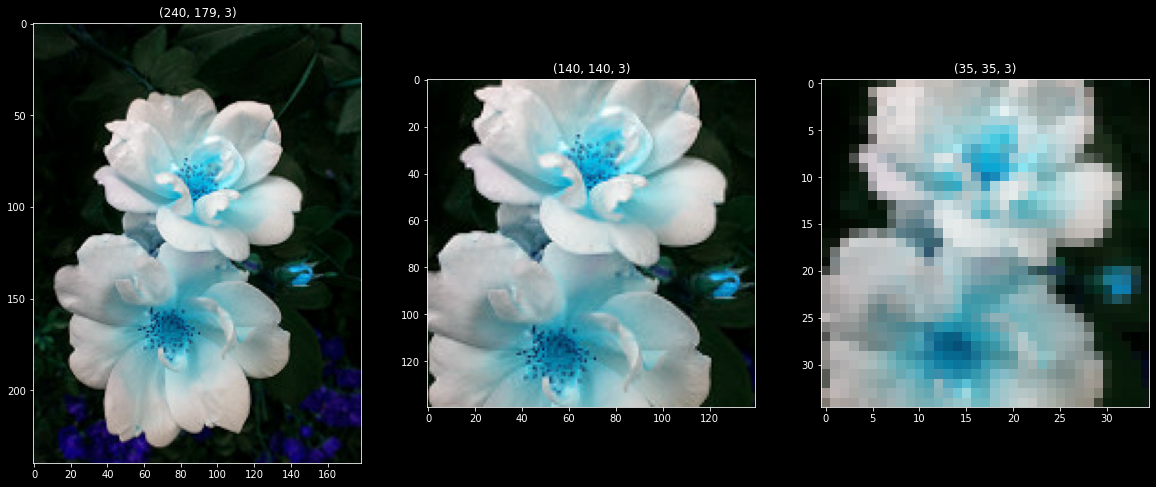

In [29]:
import matplotlib.pyplot as plt

h, w, _ = img_sample.shape
print(h, w)

## 홀수일 경우, 정확히 정사각형 image shape이 같아지지 않는 경우를 prevent
odd_h = 0
odd_w = 0
if h % 2 == 1:
    odd_h = 1
if w % 2 == 1:
    odd_w = 1

wnt_size = 140

print(odd_h, odd_w)

plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.title(img_sample.shape)
plt.imshow(img_sample)

## 정사각형으로 이미지 자르기
crop_sample = img_sample[round((h-wnt_size)/2)+odd_h:round(-(h-wnt_size)/2), round((w-wnt_size)/2)-odd_w:round(-(w-wnt_size)/2), :]
plt.subplot(1, 3, 2)
plt.title(crop_sample.shape)
plt.imshow(crop_sample)

## 정사각형 이미지를 pyramid_reduce를 통해서 downscale한다.
from skimage.transform import pyramid_reduce
down_sample = pyramid_reduce(crop_sample, downscale=4, multichannel=True)
plt.subplot(1, 3, 3)
plt.title(down_sample.shape)
plt.imshow(down_sample)

>### Input: LowRes data
>### output: HighRes data 생성하기

In [30]:
print(data_dir)
fn_makedirs(os.path.join(data_dir, 'dataset'))

C:\Users\sel04327\.keras\datasets\flower_photos


In [31]:
fn_makedirs(os.path.join(data_dir, 'dataset' ,'lowres'))
fn_makedirs(os.path.join(data_dir, 'dataset', 'highres'))

In [38]:
img_path = list(data_dir.glob('*/*.jpg'))

file_list = []
for i in range(image_count):
    file_list.append(os.path.join(img_path[i]))

In [39]:
print(file_list[:3])

['C:\\Users\\sel04327\\.keras\\datasets\\flower_photos\\daisy\\100080576_f52e8ee070_n.jpg', 'C:\\Users\\sel04327\\.keras\\datasets\\flower_photos\\daisy\\10140303196_b88d3d6cec.jpg', 'C:\\Users\\sel04327\\.keras\\datasets\\flower_photos\\daisy\\10172379554_b296050f82_n.jpg']


In [33]:
input_dir = os.path.join(data_dir, 'dataset' ,'lowres')
target_dir = os.path.join(data_dir, 'dataset', 'highres')

print(input_dir)
print(target_dir)

C:\Users\sel04327\.keras\datasets\flower_photos\dataset\lowres
C:\Users\sel04327\.keras\datasets\flower_photos\dataset\highres


>### Preprocessing 데이터 전처리

In [34]:
def preprocess_data(img_path):
    odd_h = 0
    odd_w = 0

    load_img = cv2.imread(img_path)
        
    h, w, _ = load_img.shape
    
    if h % 2 == 1:
        odd_h = 1
    if w % 2 == 1:
        odd_w = 1
    
    ## height and weidth 200 이상만 데이터 저장.
    if h < 200 or w < 200:
        return None
    
    ## 정사각형으로 이미지 자르기
    crop_sample = load_img[round((h-200)/2)+odd_h:round(-(h-200)/2), round((w-200)/2)-odd_w:round(-(w-200)/2), :]
    
    ## input: Loweres data / pyramid_reduce로 downscale 한다.
    downsample_img = pyramid_reduce(crop_sample, downscale=4, multichannel=True)
    ## output: Highres data / normalize 한다.
    norm = cv2.normalize(crop_sample.astype(np.float64), None, 0, 1, cv2.NORM_MINMAX)
    
    return downsample_img, norm

In [35]:
def create_dataset(input_dir, target_dir, batch_size, num_epochs):
    # 입력 파이프라인을 구성하는 함수
    def input_pipeline(input_path, target_path):
        # 데이터 로딩
        input_data = tf.py_function(np.load, [input_path], tf.float32)
        target_data = tf.py_function(np.load, [target_path], tf.float32)

        return input_data, target_data

    # 데이터셋 생성
    input_paths = tf.data.Dataset.list_files(input_dir + '/*.npy')
    target_paths = tf.data.Dataset.list_files(target_dir + '/*.npy')
    dataset = tf.data.Dataset.zip((input_paths, target_paths))
    dataset = dataset.map(input_pipeline, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).repeat(num_epochs)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [37]:
print(file_list[:5])

['C:\\Users\\sel04327\\.keras\\datasets\\flower_photos\\daisy\\100080576_f52e8ee070_n.jpg', 'C:\\Users\\sel04327\\.keras\\datasets\\flower_photos\\daisy\\10140303196_b88d3d6cec.jpg', 'C:\\Users\\sel04327\\.keras\\datasets\\flower_photos\\daisy\\10172379554_b296050f82_n.jpg', 'C:\\Users\\sel04327\\.keras\\datasets\\flower_photos\\daisy\\10172567486_2748826a8b.jpg', 'C:\\Users\\sel04327\\.keras\\datasets\\flower_photos\\daisy\\10172636503_21bededa75_n.jpg']


In [36]:
# 이미지 전처리 및 저장
for idx, img in enumerate(file_list):
    data = preprocess_data(img)
    if data:
        downsample_img, norm = data
        np.save(os.path.join(input_dir, str(idx) + '.npy'), downsample_img)
        np.save(os.path.join(target_dir, str(idx) + '.npy'), norm)
        

# # 데이터셋 생성
# batch_size = 32
# num_epochs = 10

# dataset = create_dataset(input_dir, target_dir, batch_size, num_epochs)

# # 훈련 데이터셋으로부터 샘플 데이터 가져오기
# for input_data, target_data in dataset.take(1):
#     print('input data shape:', input_data.shape)
#     print('target data shape:', target_data.shape)

ValueError: zero-size array to reduction operation minimum which has no identity

In [12]:
no_sel_list = []

for idx, img in enumerate(file_list):
    odd_h = 0
    odd_w = 0

    load_img = cv2.imread(img)
        
    h, w, _ = load_img.shape
    
    if h % 2 == 1:
        odd_h = 1
    if w % 2 == 1:
        odd_w = 1
    
    ## height and weidth 200 이상만 데이터 저장.
    if h < 200 or w < 200:
        no_sel_list.append(idx)
    
    else:
        ## 정사각형으로 이미지 자르기
        crop_sample = load_img[round((h-wnt_size)/2)+odd_h:round(-(h-wnt_size)/2), round((w-wnt_size)/2)-odd_w:round(-(w-wnt_size)/2), :]

        ## input: Loweres data
        ## pyramid_reduce로 downscale 한다.
        downsample_img = pyramid_reduce(crop_sample, downscale=4, multichannel=True)

        ## output: Highres data
        ## normalize 한다.
        norm = cv2.normalize(crop_sample.astype(np.float64), None, 0, 1, cv2.NORM_MINMAX)
        
        ## input_dir 저장: lowres
        np.save(os.path.join(input_dir, str(idx) + '.npy'), downsample_img)
        ## target_dir 저장: highres
        np.save(os.path.join(target_dir, str(idx) + '.npy'), norm)

print('선택되지 않는 idx 갯수:', len(no_sel_list))
print('선택된 idx 갯수:', image_count-len(no_sel_list))

선택되지 않는 idx 갯수: 398
선택된 idx 갯수: 3272


In [1]:
        # if idx < 3000:
        #     np.save(os.path.join(output_dir, 'train_lowres', str(idx) + '.npy'), downsample_img)
        #     np.save(os.path.join(output_dir, 'train_highres', str(idx) + '.npy'), norm)
        # elif idx > 2001 and idx < 3000:
        #     np.save(os.path.join(output_dir, 'val_lowres', str(idx) + '.npy'), downsample_img)
        #     np.save(os.path.join(output_dir, 'val_highres', str(idx) + '.npy'), norm)
        # elif idx > 3001:
        #     np.save(os.path.join(output_dir, 'test_lowres', str(idx) + '.npy'), downsample_img)
        #     np.save(os.path.join(output_dir, 'test_highres', str(idx) + '.npy'), norm)

>### 데이터셋 생성

In [17]:
def create_dataset(input_dir, target_dir, batch_size, num_epochs):
    # 데이터 로딩 및 전처리 함수
    def load_and_preprocess_data(input_path, target_path):
        # np.load로 numpy 배열 로딩
        input_data = np.load(input_path)
        target_data = np.load(target_path)

        # 입력 데이터 전처리
        downsample_img = input_data
        for i in range(2):
            downsample_img = pyramid_reduce(downsample_img, downscale=4, multichannel=True)
        input_data = downsample_img

        # 타겟 데이터 전처리
        norm = cv2.normalize(target_data.astype(np.float64), None, 0, 1, cv2.NORM_MINMAX)
        target_data = norm

        return input_data, target_data

    # 파일 경로 로딩
    input_paths = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.npy')]
    target_paths = [os.path.join(target_dir, f) for f in os.listdir(target_dir) if f.endswith('.npy')]

    # 파일 경로를 이용해 데이터셋 생성
    dataset = tf.data.Dataset.from_tensor_slices((input_paths, target_paths))
    dataset = dataset.map(load_and_preprocess_data)
    dataset = dataset.batch(batch_size).repeat(num_epochs)

    return dataset

In [16]:
# create dataset
dataset = create_dataset(input_dir, target_dir, batch_size=1, num_epochs=1)

# extract and plot a few samples from the dataset
for input_data, target_data in dataset.take(3):
    input_array = input_data.numpy().squeeze()
    target_array = target_data.numpy().squeeze()
    
    fig, axes = plt.subplots(ncols=2, figsize=(8,4))
    axes[0].imshow(input_array)
    axes[0].set_title('Input')
    axes[0].axis('off')
    axes[1].imshow(target_array)
    axes[1].set_title('Target')
    axes[1].axis('off')
    plt.show()

InvalidArgumentError: TypeError: expected str, bytes or os.PathLike object, not tensorflow.python.framework.ops.EagerTensor
Traceback (most recent call last):

  File "c:\Python\Python37\lib\site-packages\tensorflow\python\ops\script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "c:\Python\Python37\lib\site-packages\tensorflow\python\ops\script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "c:\Python\Python37\lib\site-packages\tensorflow\python\ops\script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "c:\Python\Python37\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\Python\Python37\lib\site-packages\numpy\lib\npyio.py", line 417, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))

TypeError: expected str, bytes or os.PathLike object, not tensorflow.python.framework.ops.EagerTensor


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

In [17]:
# 파일 이름 가져오기
input_filenames = tf.constant([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)])
target_filenames = tf.constant([os.path.join(target_dir, fname) for fname in os.listdir(target_dir)])

# 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((input_filenames, target_filenames))

>### 전체 데이터셋 크기를 구함
- train set 크기 정함
- from_tensor_slices() 메서드는 your_data를 tf.data.Dataset으로 변환합니다. 
    - take() 메서드는 데이터셋의 앞부분을 추출하여 train set으로 만들고, 
    - skip() 메서드는 추출한 부분을 제외한 나머지를 test set으로 만듭니다.

In [18]:
dataset_size = len(input_filenames)
print(dataset_size)

train_size = int(0.8 * dataset_size)

# train set과 test set으로 데이터셋을 분할합니다.
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

print(len(train_dataset), len(test_dataset))

3272
2617 655


In [20]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [19]:
type(train_dataset)
print(train_dataset.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>


In [ ]:
input_dataset = input_dataset.map(lambda x: np.load(x.numpy().decode('utf-8')))

In [21]:
def load_image(input_filenames, target_filenames):
    input_image = tf.io.read_file(input_filenames)
    input_image = tf.image.decode_png(input_image, channels=3)
    target_image = tf.io.read_file(target_filenames)
    target_image = tf.image.decode_png(target_image, channels=3)
    return input_image, target_image


dataset = train_dataset.map(load_image)

In [25]:
print(dataset)

<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None))>


In [27]:
dataset = dataset.map(lambda x: np.load(x.numpy()))
dataset = dataset.batch(1)

# 이미지 출력
for data in dataset:
    # input_image 출력
    plt.imshow(data[0])
    plt.show()  

TypeError: in user code:


    TypeError: <lambda>() takes 1 positional argument but 2 were given


>### Flip & crop: argument

In [1]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

NameError: name 'keras' is not defined